In [1]:
import torch
import torch.nn as nn

## pytorch conv1d 对任意input matrix of (M x N), 是以（M, kernel_size）向右扫做convolve

In [7]:
#example: https://www.programmersought.com/article/20634856252/

In [9]:
conv1 = nn.Conv1d(in_channels=256, out_channels=100, kernel_size=2)
input = torch.randn(32, 35, 256)
input = input.permute(0, 2, 1)   # （32, 35, 256） => (32, 256, 35)
output = conv1(input)  # (32, 256, 34)

In [10]:
output.shape

torch.Size([32, 100, 34])

In [10]:
#also confirmed from https://www.youtube.com/watch?v=CNY8VjJt-iQ  minutes: 5:58

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

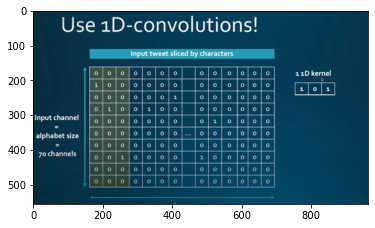

In [15]:
image = mpimg.imread("./torchnn_1DConv_demo.png")
plt.imshow(image)
plt.show()

### Convolution used in UIST

In [35]:
UIST_input = torch.randn(32, 10, 8)
conv1 = nn.Conv1d(in_channels=8, out_channels=10, kernel_size=2)
UIST_output = conv1(UIST_input.transpose(1,2))  

In [18]:
UIST_output.shape

torch.Size([32, 10, 9])

In [3]:
UIST_input = torch.randn(32, 10, 8)
UIST_input = UIST_input.permute(0,2,1)
conv1 = nn.Conv1d(in_channels=8, out_channels=10, kernel_size=2)
UIST_output = conv1(UIST_input)  


In [5]:
UIST_output.shape

torch.Size([32, 10, 9])

### NuripsDataset

In [2]:
import numpy as np
import pandas as pd
import os
import sys
import random
sys.path.insert(0, './helpers')
from utils import makedir_if_not_exist 
import models 
import brain_data

In [3]:
###experiment with size40sec_200ts

In [4]:
window_size = 200

if window_size == 10:
    num_chunk_this_window_size = 2224
elif window_size == 25:
    num_chunk_this_window_size = 2144
elif window_size == 50:
    num_chunk_this_window_size = 2016
elif window_size == 100:
    num_chunk_this_window_size = 1744
elif window_size == 150:
    num_chunk_this_window_size = 1472
elif window_size == 200:
    num_chunk_this_window_size = 1216
else:
    raise NameError('not supported window size')

In [5]:
data_dir = './data/Leon/Visual/size_40sec_200ts_stride_3ts/'
sub_file = 'sub_1.csv'

sub_feature_array, sub_label_array = brain_data.read_subject_csv(os.path.join(data_dir, sub_file), num_chunk_this_window_size = num_chunk_this_window_size)

In [7]:
sub_feature_array.shape

(1216, 200, 8)

In [8]:
data_set = brain_data.brain_dataset(sub_feature_array, sub_label_array)
data_loader = torch.utils.data.DataLoader(data_set, batch_size=13, shuffle=False)

In [9]:
## Look at the element for the dataloader

In [23]:
for i, (data_batch, labels_batch) in enumerate(data_loader):
    print('data_batch: {}; labels_batch: {}'.format(data_batch.shape, labels_batch.shape))
    

data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8]); labels_batch: torch.Size([13])
data_batch: torch.Size([13, 200, 8

In [26]:
data_batch = data_batch.unsqueeze(1)

In [27]:
data_batch.shape

torch.Size([7, 1, 200, 8])

### Explore EEGNet

In [36]:
class EEGNet(nn.Module):
    def __init__(self, num_features=8, num_timesteps=10, kernels_per_layer=2):

        super(EEGNet, self).__init__()

        #kernel_size=3, because the EEGNet paper recommand kernal_size=half sampling rate, our sampling rate is ~5.5Hz 
        self.firstConv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 3), stride=1, padding=(0,1), bias=False), 
            nn.BatchNorm2d(num_features=16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        #groups=16, because the EEGNet paper recommand number of spatial filters to learn within each temporal convolution is 2
        #padding='valid' as in the EEGNet paper
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 16 * kernels_per_layer, kernel_size=(num_features, 1), stride=(1, 1), padding='valid', groups=16, bias=False),
            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#             nn.ReLU(),
            nn.ELU(), #use elu instead, as in the EEGNet paper
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(p=0.25)
        )

        #depthwise convolution follow by pointwise convolution (pointwise convolution is just Conv2d with 1x1 kernel)
        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32 * kernels_per_layer, kernel_size=(1, 3), stride=(1, 1), padding=(0, 7), groups=32, bias=False),
            nn.Conv2d(32, 16, kernel_size=1, bias=False),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
#             nn.ReLU(),
            nn.ELU(), #use elu instead, as in the EEGNet paper
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(p=0.25)
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=32, out_features=3, bias=True)
        )

    def forward(self, x):
        x = self.firstConv(x.transpose(2,3))
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        # print(x.shape)
        x = x.view(-1, self.classifier[0].in_features)
        x = self.classifier(x)
        return x


In [37]:
model = EEGNet(num_features=8, num_timesteps=200, kernels_per_layer=2)

In [38]:
output_batch = model(data_batch)

TypeError: conv2d(): argument 'padding' (position 5) must be tuple of ints, not str